# Wi-Fi Network Security Threat Detection Using Machine Learning

In [9]:
# Define the path to the pcap files and the output directory
pcap_directory = "../datasets/wifi"
output_directory = "./model_output"

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scapy.utils import rdpcap
from scapy.layers.inet import IP
import warnings
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import joblib
from datetime import datetime
import os

# Suppress Scapy warnings
warnings.filterwarnings('ignore')

## 1. Load PCAP Files

In [10]:
def read_pcap(file_path):
    """
    Read pcap file and convert to DataFrame
    
    Parameters:
    file_path (str): Path to the PCAP file
    
    Returns:
    pandas.DataFrame: DataFrame containing packet information
    """
    try:
        packets = rdpcap(file_path)
        if not packets:
            print(f"Warning: {file_path} is empty")
            return pd.DataFrame()
            
        data = []
        
        for packet in packets:
            try:
                # Extract basic features
                timestamp = float(packet.time)
                if IP in packet:
                    src_ip = packet[IP].src
                    dst_ip = packet[IP].dst
                    protocol = packet[IP].proto
                    size = len(packet)
                    
                    data.append({
                        'timestamp': timestamp,
                        'src_ip': src_ip,
                        'dst_ip': dst_ip,
                        'protocol': protocol,
                        'size': size
                    })
            except Exception as e:
                continue
                
        return pd.DataFrame(data)
        
    except FileNotFoundError:
        print(f"Error: File {file_path} not found")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error reading {file_path}: {str(e)}")
        return pd.DataFrame()

def process_multiple_pcaps(directory):
    """
    Process multiple pcap files from a directory
    
    Parameters:
    directory (str): Path to directory containing PCAP files
    
    Returns:
    pandas.DataFrame: Combined DataFrame with all packet data
    """
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} not found")
        
    all_data = pd.DataFrame()
    
    for file in os.listdir(directory):
        if file.endswith('.pcap'):
            file_path = os.path.join(directory, file)
            print(f"Processing {file}...")
            df = read_pcap(file_path)
            
            if not df.empty:
                all_data = pd.concat([all_data, df])
    
    if all_data.empty:
        raise ValueError("No valid data found in any of the PCAP files")
        
    all_data = all_data.sort_values('timestamp')
    all_data['datetime'] = pd.to_datetime(all_data['timestamp'], unit='s')
    return all_data

df = process_multiple_pcaps(pcap_directory)

Processing ap_traffic_20241029_004819.pcap...
Processing ap_traffic_20241101_153534.pcap...
Processing ap_traffic_20241117_225909.pcap...
Processing ap_traffic_20241101_155634.pcap...
Processing ap_traffic_20241117_224908.pcap...
Processing ap_traffic_20241101_171717.pcap...
Processing ap_traffic_20241101_151134.pcap...
Processing ap_traffic_20241031_102609.pcap...
Processing ap_traffic_20241022_235548.pcap...
Processing ap_traffic_20241031_103254.pcap...
Processing ap_traffic_20241101_161019.pcap...
Processing ap_traffic_20241101_153955.pcap...
Processing ap_traffic_20241025_141331.pcap...
Processing ap_traffic_20241029_092855.pcap...
Processing ap_traffic_20241029_092603.pcap...
Processing ap_traffic_20241025_135801.pcap...
Processing ap_traffic_20241101_151515.pcap...
Processing ap_traffic_20241022_234522.pcap...
Processing ap_traffic_20241117_224304.pcap...
Processing ap_traffic_20241022_235036.pcap...
Processing ap_traffic_20241101_153103.pcap...
Processing ap_traffic_20241101_165

## 2. Visualize raw data

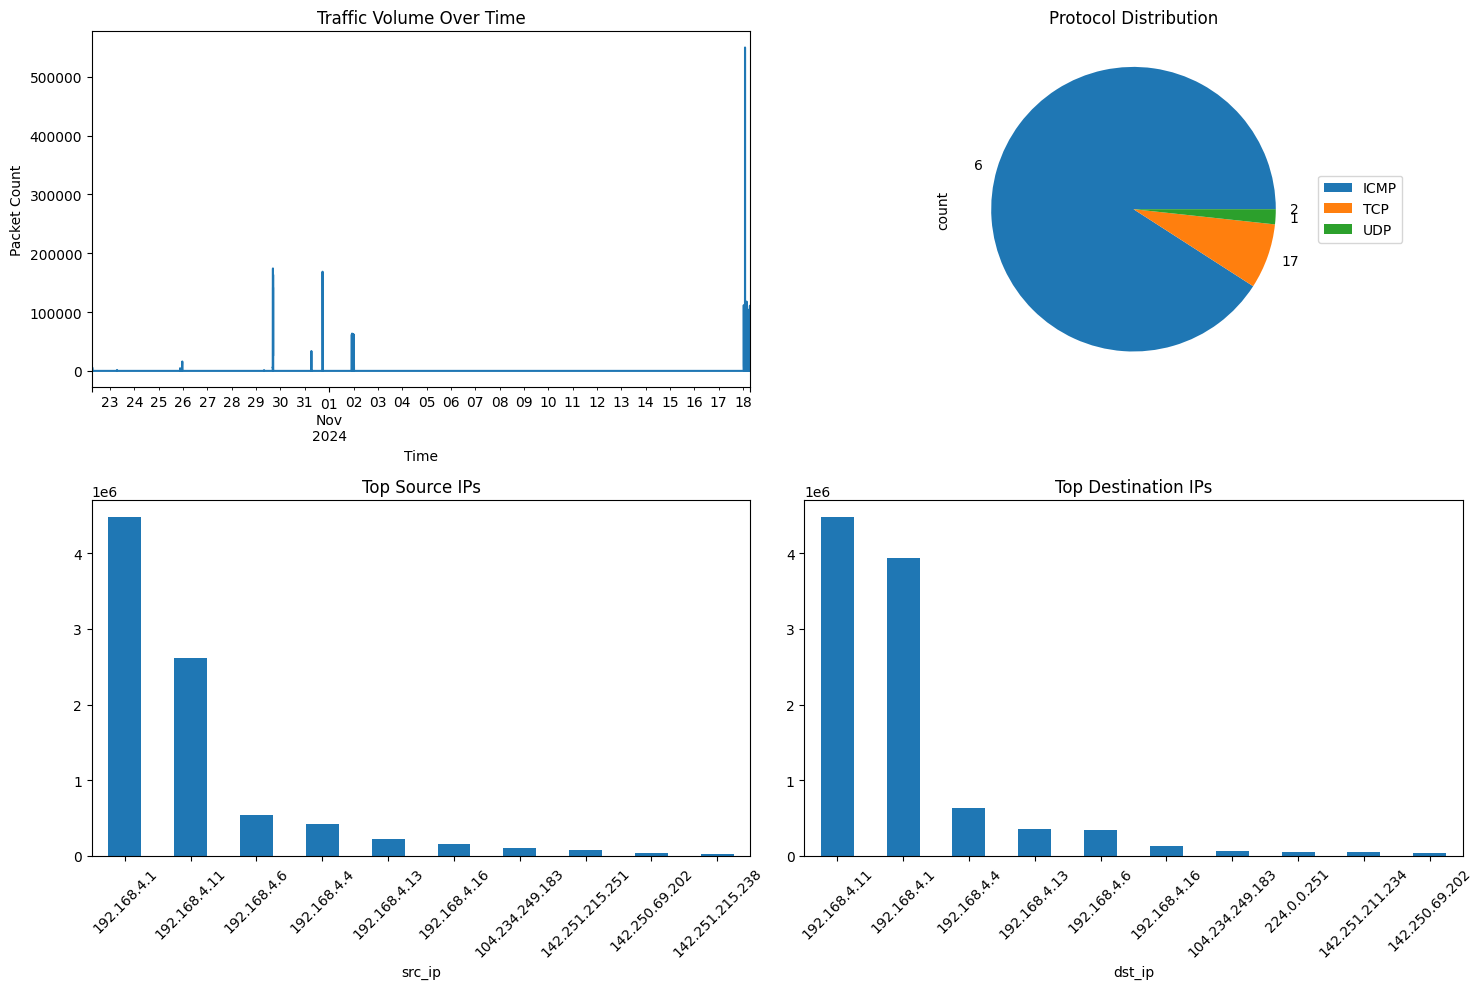

In [21]:
def plot_traffic_analysis(df):
    """
    Create various plots for traffic analysis
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing packet information
    
    Output:
    Displays four plots:
    - Traffic volume over time
    - Protocol distribution
    - Packet size distribution
    - Top source IPs
    """
    plt.figure(figsize=(15, 10))
    
    # Traffic volume over time
    plt.subplot(2, 2, 1)
    df.resample('1Min', on='datetime').size().plot()
    plt.title('Traffic Volume Over Time')
    plt.xlabel('Time')
    plt.ylabel('Packet Count')
    
    # Protocol distribution
    plt.subplot(2, 2, 2)
    df['protocol'].value_counts().plot(kind='pie')
    # Add legend with protocol names
    plt.legend(['ICMP', 'TCP', 'UDP'], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Protocol Distribution')
    
    # Packet size distribution
    # plt.subplot(2, 2, 3)
    # sns.histplot(df['size'], bins=50)
    # plt.title('Packet Size Distribution')
    
    # Top source IPs
    plt.subplot(2, 2, 3)
    df['src_ip'].value_counts().head(10).plot(kind='bar')
    plt.title('Top Source IPs')
    plt.xticks(rotation=45)

    # Top destination IPs
    plt.subplot(2, 2,4)
    df['dst_ip'].value_counts().head(10).plot(kind='bar')
    plt.title('Top Destination IPs')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

plot_traffic_analysis(df)

## 3. Feature Engineering

In [13]:
def engineer_features(df, window='1Min'):
    """
    Create features for anomaly detection
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame with packet data
    window (str): Time window for aggregation (default: '1Min')
    
    Returns:
    pandas.DataFrame: Engineered features for anomaly detection
    
    Features created:
    - packet_count: Number of packets in time window
    - avg_packet_size: Average size of packets
    - std_packet_size: Standard deviation of packet sizes
    - unique_src_ips: Number of unique source IPs
    - unique_dst_ips: Number of unique destination IPs
    - protocol_diversity: Number of different protocols used
    - total_bytes: Total traffic volume in bytes
    - protocol_X_ratio: Ratio of each protocol's usage
    """
    features = []
    
    # Group by time windows
    for time_window in df.resample(window, on='datetime'):
        window_time, window_data = time_window
        
        # Calculate features for each window
        feature_dict = {
            'timestamp': window_time,
            'packet_count': len(window_data),
            'avg_packet_size': window_data['size'].mean(),
            'std_packet_size': window_data['size'].std(),
            'unique_src_ips': window_data['src_ip'].nunique(),
            'unique_dst_ips': window_data['dst_ip'].nunique(),
            'protocol_diversity': window_data['protocol'].nunique(),
            'total_bytes': window_data['size'].sum()
        }
        
        # Add protocol percentages
        protocol_counts = window_data['protocol'].value_counts(normalize=True)
        for protocol in protocol_counts.index:
            feature_dict[f'protocol_{protocol}_ratio'] = protocol_counts[protocol]
            
        features.append(feature_dict)
    
    return pd.DataFrame(features).fillna(0)

features_df = engineer_features(df)

## 4. Model Training

In [14]:
def train_isolation_forest(features):
    """
    Train Isolation Forest model
    
    Parameters:
    features (pandas.DataFrame): Engineered features
    
    Returns:
    tuple: (trained model, feature scaler)
    
    Note:
    - contamination=0.1 assumes 10% of data points are anomalies
    - n_estimators=100 provides good balance of accuracy and performance
    """
    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features.drop('timestamp', axis=1))
    
    # Train model
    model = IsolationForest(
        n_estimators=100,  # Number of trees
        max_samples='auto',  # Subset size to train each tree
        contamination=0.1,   # Expected proportion of anomalies
        random_state=42      # For reproducibility
    )
    
    model.fit(scaled_features)
    
    return model, scaler

model, scaler = train_isolation_forest(features_df)

## 5. Evaluate model

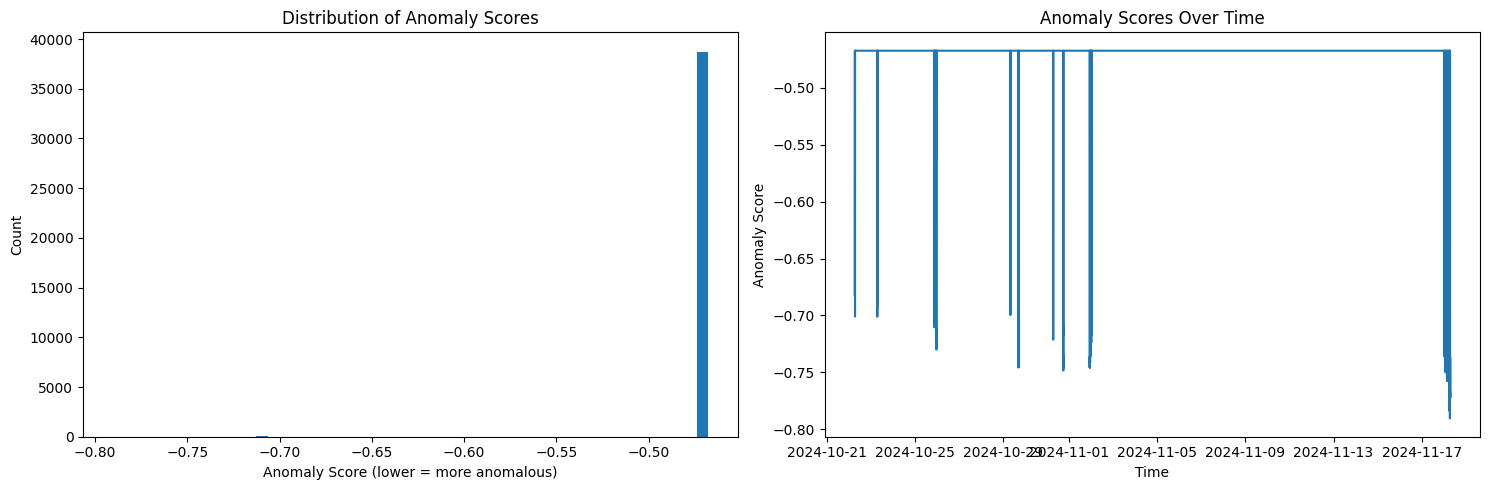

Silhouette Score: 0.995
Note: Silhouette Score ranges from -1 to 1, where higher values indicate better-defined clusters


In [15]:
def evaluate_model(model, features, scaler):
    """
    Evaluate the model and visualize results
    
    Parameters:
    model: Trained Isolation Forest model
    features (pandas.DataFrame): Feature data
    scaler: Fitted StandardScaler
    
    Returns:
    tuple: (anomaly scores, predictions)
    
    Displays:
    - Distribution of anomaly scores
    - Anomaly scores over time
    - Silhouette score
    """
    # Get anomaly scores
    scaled_features = scaler.transform(features.drop('timestamp', axis=1))
    scores = model.score_samples(scaled_features)
    predictions = model.predict(scaled_features)
    
    # Plot anomaly scores
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(scores, bins=50)
    plt.title('Distribution of Anomaly Scores')
    plt.xlabel('Anomaly Score (lower = more anomalous)')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    plt.plot(features['timestamp'], scores)
    plt.title('Anomaly Scores Over Time')
    plt.xlabel('Time')
    plt.ylabel('Anomaly Score')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate silhouette score for validation
    silhouette_avg = silhouette_score(
        scaled_features, 
        predictions,
        metric='euclidean'
    )
    print(f'Silhouette Score: {silhouette_avg:.3f}')
    print('Note: Silhouette Score ranges from -1 to 1, where higher values indicate better-defined clusters')
    
    return scores, predictions

scores, predictions = evaluate_model(model, features_df, scaler)

## 6. Save Model

In [17]:
def save_model(model, scaler, output_dir):
    """
    Save the trained model and scaler
    
    Parameters:
    model: Trained Isolation Forest model
    scaler: Fitted StandardScaler
    output_dir (str): Directory to save model files
    """
    os.makedirs(output_dir, exist_ok=True)
    
    joblib.dump(model, os.path.join(output_dir, 'wifi_isolation_forest_model.joblib'))
    joblib.dump(scaler, os.path.join(output_dir, 'wifi_scaler.joblib'))
    print(f"Model and scaler saved to {output_dir}")

save_model(model, scaler, output_directory)

Model and scaler saved to ./model_output
